# Averaged XGBoost and LightGBM model
---

In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import stats, norm, skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.special import boxcox1p
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
np.random.seed(2)

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
train = train.drop('Id', axis=1)
train.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Filling NaNs

## TODO: spend some more time on these columns

### 1: strings

In [4]:
cols_with_none_as_nan = [
    "PoolQC", 
    "MiscFeature", 
    "Alley", 
    "Fence", 
    "FireplaceQu", 
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'Electrical', 
    'BsmtFinType1', 
    'BsmtFinType2', 
    "MasVnrType",
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'KitchenQual',
    'Functional',
    'SaleType']


o = train.dtypes[train.dtypes==object].index
print(o)

# fill missing text fields with a default string
object_columns = train[o]
test_object_columns = test[o]

# for these colunms the string 'None' will be inserted in place of nan
for col in cols_with_none_as_nan:
    object_columns.loc[:, col] = object_columns.loc[:, col].fillna('None')
    test_object_columns.loc[:, col] = test_object_columns.loc[:, col].fillna('None')

remaining_fix = object_columns.isnull().sum()
print('Fixes remaining on train set\n', remaining_fix[remaining_fix>0])

remaining_fix = test_object_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


/home/daniele/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


# From string to ordinal
Many categorical features contain **ordinal** values; the chart that follows shows that in most cases, the category influences the SalePrice label.

In [5]:
# Base scale, taken from 'OverallCond' feature
#   10   Very Excellent
#   9    Excellent
#   8    Very Good
#   7    Good
#   6    Above Average   
#   5    Average
#   4    Below Average   
#   3    Fair
#   2    Poor
#   1    Very Poor

#   Ex   Excellent (100+ inches) 
#   Gd   Good (90-99 inches)
#   TA   Typical (80-89 inches)
#   Fa   Fair (70-79 inches)
#   Po   Poor (&lt;70 inches
#   NA   No Basement

quals_mapping = {
    "Ex": 9,
    "Gd": 7,
    "Av": 5,
    "TA": 5,
    "Fa": 3,
    "Po": 2,
    "NA": 0,
    "None": 0
}
quals_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', ]

for c in object_columns.columns:
    if c in quals_columns:
        vals = np.unique(object_columns[c])
        for v in quals_mapping:
            object_columns.loc[:,c] = object_columns[c].replace(to_replace=v, value=quals_mapping[v])
            test_object_columns.loc[:,c] = test_object_columns[c].replace(to_replace=v, value=quals_mapping[v])


/home/daniele/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In order to make the category influence the predicted price with the correct amount, I'm going to exchange each category with the mean saleprice value for all the entries with that category.

### 2: numerics

In [6]:
numeric_columns = train.select_dtypes(include=[int, float])

remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

test_numeric_columns = test.select_dtypes(include=[int, float])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Fixes remaining on train set
 LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
Fixes remaining on test set
 LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [7]:
cols_with_zero_as_nan = ['MasVnrArea', 
                         'GarageYrBlt',
                         'BsmtFinSF1',
                         'BsmtFinSF2',
                         'BsmtUnfSF',
                         'TotalBsmtSF',
                         'BsmtFullBath',
                         'BsmtHalfBath',
                         'GarageCars',
                         'GarageArea',
                        ]
cols_with_mean_as_nan = ['LotFrontage']

# for these colunms the mean will be inserted in place of nan
for col in cols_with_mean_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(numeric_columns[col].mean())
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(test_numeric_columns[col].mean())

# for these colunms a zero will be inserted in place of nan
for col in cols_with_zero_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(0)
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(0)


remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


In [8]:
## Removing outliers in OverallQual and SalePrice

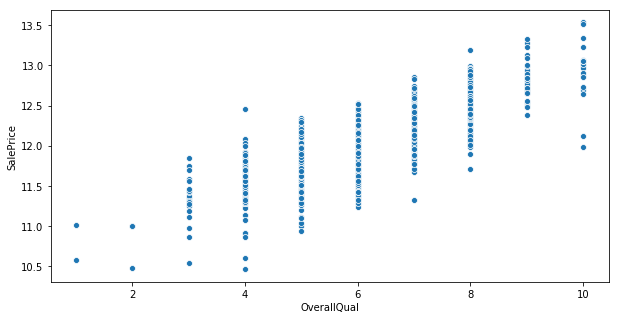

In [9]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns.loc[:,'OverallQual'], y=np.log1p(train['SalePrice']))
plt.show()


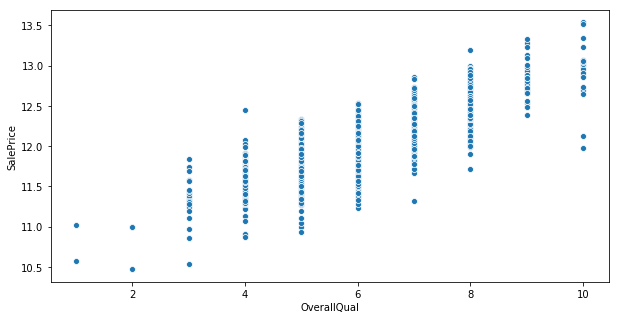

In [10]:
for d in numeric_columns[numeric_columns['OverallQual'] == 4].index:
    if np.log1p(numeric_columns.loc[d,'SalePrice']) < 10.8:
        numeric_columns = numeric_columns.drop(d, axis=0)
        object_columns = object_columns.drop(d, axis=0)

plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns.loc[:,'OverallQual'], y=np.log1p(train['SalePrice']))
plt.show()


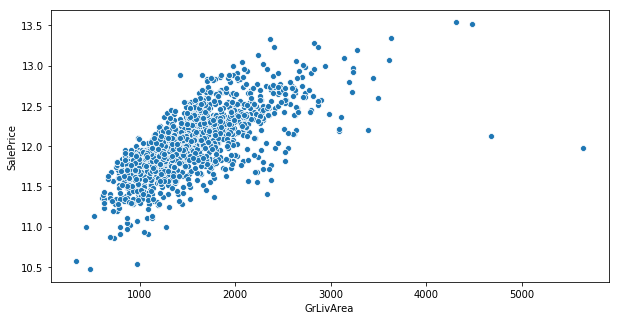

In [11]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns['GrLivArea'], y=np.log1p(train['SalePrice']))
plt.show()


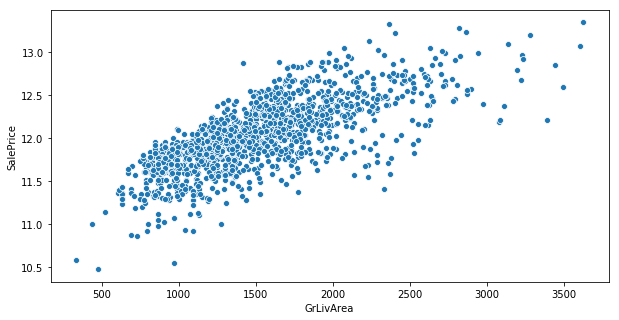

In [12]:
for d in numeric_columns[numeric_columns['GrLivArea'] > 4000].index:
    numeric_columns = numeric_columns.drop(d, axis=0)
    object_columns = object_columns.drop(d, axis=0)

plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns['GrLivArea'], y=np.log1p(train['SalePrice']))
plt.show()


# Features skewness

In [13]:
def fix_skewness(dataframe):
    skewed_feats = dataframe.apply(lambda x: abs(skew(x.dropna()))).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skewed_feats})
    skewness = skewness[abs(skewness) > 0.75].dropna()
    print("There are {} skewed numerical features to transform".format(skewness.shape[0]))
    print("\nSkew > .75 in numerical features: \n")
    print(skewness)
    # Fix skewness
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        if feat == 'SalePrice': continue
        dataframe[feat] = boxcox1p(dataframe[feat], lam)
    print('Fixed skewness')

#fix_skewness(numeric_columns)
#fix_skewness(test_numeric_columns)


# Enconding string columns with LabelEncoder

In [14]:

strings = np.array([])
for c in object_columns.columns:
    if c not in quals_columns:
        strings = np.append(strings, pd.unique(object_columns[c].values))

for c in test_object_columns.columns:
    if c not in quals_columns:
        strings = np.append(strings, pd.unique(test_object_columns[c].values))

print(len(strings), 'distinct labels generated')

labeler = LabelEncoder()
labeler.fit(strings)

for c in object_columns.columns:
    if c not in quals_columns:
        object_columns.loc[:,c] = labeler.transform(object_columns.loc[:,c])
        test_object_columns.loc[:,c] = labeler.transform(test_object_columns.loc[:,c])

object_columns[0:5]

422 distinct labels generated


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,129,123,111,136,86,12,84,75,40,112,...,17,127,5,5,168,0,111,111,160,113
1,129,123,111,136,86,12,52,75,158,56,...,17,127,5,5,168,0,111,111,160,113
2,129,123,111,80,86,12,84,75,40,112,...,17,127,5,5,168,0,111,111,160,113
3,129,123,111,80,86,12,46,75,47,112,...,49,157,5,5,168,0,111,111,160,10
4,129,123,111,80,86,12,52,75,109,112,...,17,127,5,5,168,0,111,111,160,113


# Assembling the datasets

In [15]:
# final train dataset
train_ds = object_columns.join(numeric_columns)
train_ds["SalePrice"] = np.log1p(train_ds["SalePrice"])

# test dataset
test_ds = test_object_columns.join(test_numeric_columns)

#correlation matrix
corrmat = train_ds.corr()['SalePrice']
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);

best_columns = corrmat[abs(corrmat) > 0.0].index
train_ds = train_ds[best_columns]
test_ds = test_ds[best_columns.drop('SalePrice')]


In [16]:
X_train = (train_ds.values[:,:-1])
y_train = np.asarray([[t] for t in (train_ds.values[:,-1])])
X_test = test_ds.values

print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)
print('Test set shape', test_ds.shape)


Training set features shape (1454, 79)
Training set labels shape (1454, 1)
Test set shape (1459, 79)


#### RobustScaler

In [17]:
print(test_ds.dtypes[test_ds.dtypes==object])

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train))
X_test = pd.DataFrame(transformer.transform(X_test))


Series([], dtype: object)


In [18]:
print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)


Training set features shape (1454, 79)
Training set labels shape (1454, 1)


## Training functions

In [19]:
def train_model(depth, learning_rate, n_estimators, model_type='xgb'):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(learning_rate=learning_rate, max_depth=depth, 
                                 n_estimators=n_estimators,
                                 silent=1,
                                 random_state =7, nthread = -1)
    if model_type == 'lgb':
        model = lgb.LGBMRegressor(learning_rate=learning_rate, max_depth=depth, 
                                 n_estimators=n_estimators,
                                 silent=1,
                                 random_state =7, nthread = -1)
    score = rmsle_cv(model)
    print(model_type, " score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
    return score

#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.flatten(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# Training: XGBoost


In [21]:

result = []
for depth in range(4, 5):
    for learning_rate in range(3, 4, 1):
        for n_estimators in range(4400, 4600, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='xgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


xgb  score: depth=4 lr=0.03 est=4400 -> mean:0.11493 std:0.0151


In [22]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


,depth,learning_rate,n_estimators,score_mean,score_std
count,1.0,1.00,1.0,1.000000,1.000000
mean,4.0,0.03,4400.0,0.114934,0.015065
std,NaN,NaN,NaN,NaN,NaN
min,4.0,0.03,4400.0,0.114934,0.015065
25%,4.0,0.03,4400.0,0.114934,0.015065
50%,4.0,0.03,4400.0,0.114934,0.015065
75%,4.0,0.03,4400.0,0.114934,0.015065
max,4.0,0.03,4400.0,0.114934,0.015065


In [23]:
best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])


Best params = 
 depth               4.000000
learning_rate       0.030000
n_estimators     4400.000000
score_mean          0.114934
score_std           0.015065
Name: 0, dtype: float64


* Best params = 
* depth               4.000000
* learning_rate       0.030000
* n_estimators     4400.000000
* score_mean          0.122068
* score_std           0.009581


In [24]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_xgb = xgb.XGBRegressor(learning_rate=learning_rate, max_depth=depth, 
                         n_estimators=n_estimators,
                         silent=1,
                         random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_train)
print('RMSLE XGB = ', rmsle(y_train, y_pred))
np.expm1(y_pred[0:5])

Xgboost score: depth=4 lr=0.03 est=4400 -> mean:0.11493 std:0.0151
RMSLE XGB =  0.0051430916454018975


array([208532.14, 182002.48, 222692.34, 140014.48, 252886.62],
      dtype=float32)

* Xgboost score: depth=4 lr=0.03 est=4400 -> mean:0.12207 std:0.0096
* RMSLE XGB =  0.07584312944985448


(1454, 1)
(1454, 1)
(1454,)


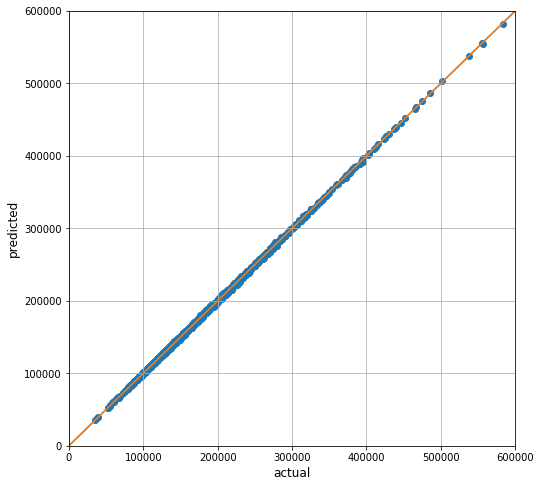

In [25]:
plt.figure(figsize=(8, 8))
y_pred = model_xgb.predict(X_train)
print(y_train.shape)
print(y_train.shape)
print(y_pred.shape)
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.grid()
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Training: lightgbm


In [26]:
result = []
for depth in range(4, 5):
    for learning_rate in range(3, 3, 1):
        for n_estimators in range(1600, 2000, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='lgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


lgb  score: depth=3 lr=0.03 est=1200 -> mean:0.11431 std:0.0159
lgb  score: depth=3 lr=0.03 est=1400 -> mean:0.11457 std:0.0159
lgb  score: depth=3 lr=0.03 est=1600 -> mean:0.11489 std:0.0159
lgb  score: depth=3 lr=0.03 est=1800 -> mean:0.11530 std:0.0158


In [27]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


,depth,learning_rate,n_estimators,score_mean,score_std
count,4.0,4.00,4.00000,4.000000,4.000000
mean,3.0,0.03,1500.00000,0.114765,0.015868
std,0.0,0.00,258.19889,0.000428,0.000036
min,3.0,0.03,1200.00000,0.114307,0.015814
25%,3.0,0.03,1350.00000,0.114503,0.015865
50%,3.0,0.03,1500.00000,0.114727,0.015884
75%,3.0,0.03,1650.00000,0.114989,0.015888
max,3.0,0.03,1800.00000,0.115299,0.015891


In [28]:
best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])


Best params = 
 depth               3.000000
learning_rate       0.030000
n_estimators     1200.000000
score_mean          0.114307
score_std           0.015887
Name: 0, dtype: float64


* Best params = 
* depth               4.000000
* learning_rate       0.020000
* n_estimators     1600.000000
* score_mean          0.126387
* score_std           0.010963


In [29]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_lgb = lgb.LGBMRegressor(learning_rate=learning_rate, max_depth=depth, 
                         n_estimators=n_estimators,
                         silent=1,
                         random_state =7, nthread = -1)


score = rmsle_cv(model_lgb)
print("lgb score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))

model_lgb.fit(X_train, y_train.flatten())
y_pred = model_lgb.predict(X_train)

print('RMSLE LGB = ', rmsle(y_train, y_pred))

np.expm1(y_pred[0:5])

lgb score: depth=3 lr=0.03 est=1200 -> mean:0.11431 std:0.0159
RMSLE LGB =  0.0618131706199214


array([202150.27000782, 173652.55039272, 208916.94995403, 149637.24774764,
       287548.29511262])

* lgb score: depth=4 lr=0.02 est=1600 -> mean:0.12639 std:0.0110
* RMSLE LGB =  0.05778702152750832


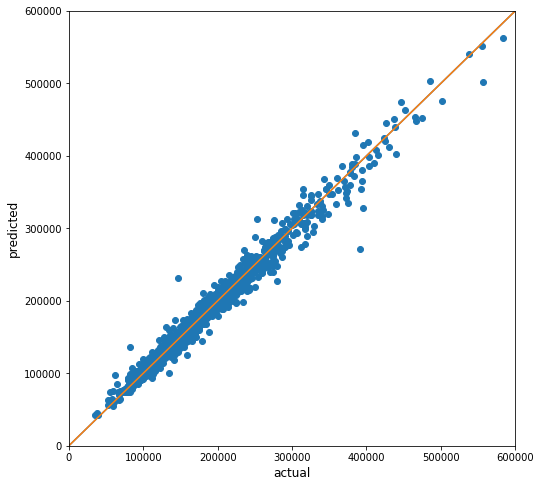

In [30]:

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Averaged model

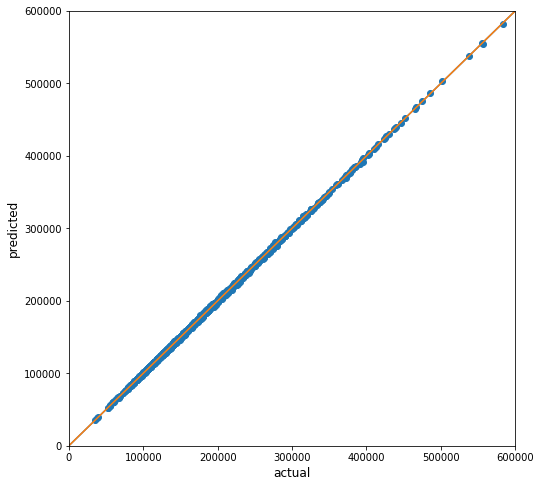

RMSLE LGB =  0.0051430916454018975


In [31]:
#avg_predict = (model_lgb.predict(X_train) + model_xgb.predict(X_train)) / 2
avg_predict = (model_xgb.predict(X_train))
y_pred = avg_predict

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()

print('RMSLE LGB = ', rmsle(y_train, y_pred))



# Target: RMSLE LGB =  0.06539346038526068


In [32]:
# Submission
print(np.expm1(model_xgb.predict(X_test)[0:5]))
print(np.expm1(model_lgb.predict(X_test)[0:5]))
avg_predict = (model_xgb.predict(X_test) + model_lgb.predict(X_test)) / 2
subm_predict = np.expm1(avg_predict)

dsubm_predict = pd.DataFrame(subm_predict)
dsubm_predict['Id'] = test.values[:,0]
dsubm_predict.columns = ['SalePrice', 'Id']

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]


[122657.14 171150.34 193669.03 195911.4  180460.78]
[122163.40666975 163091.7902661  187160.71495893 188217.58097117
 186112.83483665]


,SalePrice,Id
0,122410.024102,1461
1,167072.484441,1462
2,190387.062293,1463
3,192025.961237,1464
4,183265.024689,1465
5,174032.843460,1466
6,166809.478160,1467
7,166910.304101,1468
8,176880.755878,1469
9,126196.055911,1470


# Best score on kaggle: 0.12276